In [6]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

In [24]:
def plot_data(filter_data, throughput_data, title):
    f, axs = plt.subplots(1,2, figsize=(6,3))

    ax = axs[0]
    index = ['Simple','Markov','Racz','MaxEnt']
    filter_data = [d / filter_data[0] for d in filter_data]
    data = {'amount': filter_data}
    trans = pd.DataFrame(data=data,index=index)

    #Plot and label
    my_plot = trans.plot(ax=ax, kind='bar', stacked=True, legend=None)
    ax.set_ylabel('Fraction of queries hit')
    ax.set_xlabel('Cascade Stage')
    ax.set_xticklabels(labels=index, rotation='-45')
    ax.yaxis.grid(True)
    
    pos_offset = 0.05
    loop = 0
    for i, row in trans.iterrows():
        y = row['amount'] + pos_offset
        my_plot.annotate("{:,.3f}".format(np.absolute(row['amount'])),(loop,y),ha="center")
        loop += 1
    my_plot.set_ylim(ymax=1.2)

    ### Throughput ###
    ax = axs[1]
    index = ['Baseline','+Simple','+Markov','+Racz']
    data = {'amount': throughput_data}
    trans = pd.DataFrame(data=data,index=index)

    trans.plot(ax=ax, kind='bar', legend=None)
#     ax.set_yscale('log')
    ax.set_ylabel('Throughput (QPS)')
    ax.set_xlabel('Cascade Stage')
    ax.set_xticklabels(labels=index, rotation='-45')
    ax.yaxis.grid(True)

    f.suptitle(title, y=1.02)
    f.tight_layout()
#     plt.savefig("cascade_{}_1.pdf".format(title.lower()), bbox_inches='tight')
    plt.show()
    
def plot_data_2(throughput_data, time_data, title):
    f, axs = plt.subplots(1,2, figsize=(6,3))
    
    ax = axs[0]
    index = ['Overall','Simple','Markov','Moment','MaxEnt']
    data = {'amount': throughput_data}
    trans = pd.DataFrame(data=data,index=index)

    trans.plot(ax=ax, kind='bar', legend=None)
    ax.set_yscale('log')
    ax.set_ylabel('Stage throughput (QPS)')
    ax.set_xlabel('Cascade Stage')
    ax.set_xticklabels(labels=index, rotation='-45')
    ax.yaxis.grid(True)

    ### Time ###
    ax = axs[1]
    index = ['Simple','Markov','Moment','MaxEnt']
    data = {'amount': time_data}
    trans = pd.DataFrame(data=data,index=index)
    
    my_plot = trans.plot(ax=ax, kind='bar', stacked=True, legend=None)
    ax.set_yscale('log')
    ax.set_ylabel('Fraction of time spent')
    ax.set_xlabel('Cascade Stage')
    ax.set_xticklabels(labels=index, rotation='-45')
    ax.yaxis.grid(True)
    pos_offset = 1.2
    loop = 0
    for i, row in trans.iterrows():
        y = row['amount'] * pos_offset
        my_plot.annotate("{:,.3f}".format(np.absolute(row['amount'])),(loop,y),ha="center")
        loop += 1
    my_plot.set_ylim(ymax=3)
    
    f.suptitle(title, y=1.02)
    f.tight_layout()
#     plt.savefig("cascade_{}_2.pdf".format(title.lower()), bbox_inches='tight')
    plt.show()

In [3]:
# filter_data = [1488,722,109,70]
# lesion_data = [285.047634,296.617673,3166.879373,4224.951114]
# plot_data(filter_data, lesion_data, 'Wikipedia')

In [1]:
# throughput_data = [4639.714375, 6954083.420960, 776750.836191, 79027.311549, 223.457743]
# time_data = [0.000538, 0.002758, 0.004212, 0.992492]
# plot_data_2(throughput_data, time_data, 'Wikipedia')

In [2]:
# filter_data = [10096,-9394,-556,-77,69]
# throughput_data = [4825.119526, 15039251.612519, 619012.683588, 45916.483577, 33.055502]
# plot_data(filter_data, throughput_data, 'Milan')

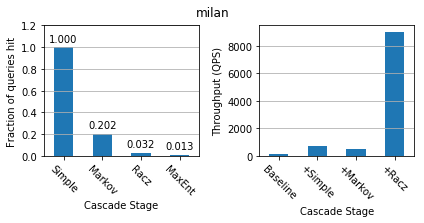

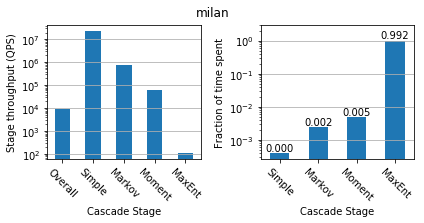

In [140]:
# results = pd.read_csv("../javamsketch/results/cascade_milan_1519110778.csv")
# results = pd.read_csv("../javamsketch/results/cascade_milan_1519168350.csv")
results = pd.read_csv("../javamsketch/results/cascade_milan_1519249176.csv")
cRow = results[(results['simple'] == True) & (results['markov'] == True) & (results['racz'] == True)]
filter_data = cRow[['simple_hit', 'markov_hit', 'racz_hit', 'maxent_hit']].squeeze().tolist()
lesion_data = results.loc[:,'overall_throughput'].dropna().tolist()
throughput_data = cRow[['overall_throughput', 'simple_throughput', 'markov_throughput', 'racz_throughput', 'maxent_throughput']].squeeze().tolist()
throughput_data = [float(t) for t in throughput_data]
time_data = cRow[['simple_time', 'markov_time', 'racz_time', 'maxent_time']].squeeze().tolist()
plot_data(filter_data, lesion_data, "milan")
plot_data_2(throughput_data, time_data, "milan")

In [143]:
def plot_data_3(apl_times, merge_times, query_times, title):
    f, axs = plt.subplots(1,1, figsize=(6,3))
    ax = axs
    x = range(6)
    index = ['?', 'Baseline', '+Simple', '+Markov', '+Racz', 'Yahoo 1', 'Yahoo 2']
#     data = {'amount': mb_data}
#     trans = pd.DataFrame(data=data,index=index)
    
#     my_plot = trans.plot(ax=ax, kind='bar', stacked=True, legend=None)
    
#     p1 = plt.bar(x, apl_times, color='b')
    p2 = plt.bar(x, merge_times, color='r')
    p3 = plt.bar(x, query_times, bottom=merge_times, color='g')
#     ax.set_yscale('log')
    ax.set_ylabel('Time per run (s)')
    ax.set_xlabel('Sketch')
    ax.set_xticklabels(labels=index, rotation='-45')
    ax.yaxis.grid(True)
    ax.set_xticks(x, index)
    ax.legend((p2[0], p3[0]), ('Merge', 'Query'))
    
#     pos_offset = 0.1 * trans['amount'].min()
#     loop = 0
#     for i, row in trans.iterrows():
#         y = row['amount'] + pos_offset
#         my_plot.annotate("{:,.3f}".format(np.absolute(row['amount'])),(loop,y),ha="center")
#         loop += 1
#     plt.set_ylim(ymax=trans['amount'].max() + 5)
    
    plt.ylim(ymax=20)
    f.suptitle(title, y=1.02)
    f.tight_layout()
    plt.savefig("cascade_{}_3.pdf".format(title.lower()), bbox_inches='tight')
    plt.show()

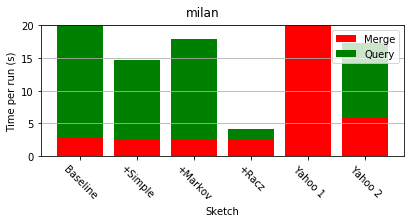

In [144]:
apl_times = results.loc[:,'avg_apltime'].dropna().tolist()
merge_times = results.loc[:,'avg_mergetime'].dropna().tolist()
query_times = results.loc[:,'avg_querytime'].dropna().tolist()

plot_data_3(apl_times, merge_times, query_times, "milan")

In [118]:
def plot_data_4(apl_times, merge_times, query_times, title):
    f, axs = plt.subplots(2,1, figsize=(6,3), sharex=True)
    axs[1].set_ylim(0, 15)
    axs[0].set_ylim(60, 70)
    x = range(6)
    index = ['Baseline', '+Simple', '+Markov', '+Racz', 'Yahoo 1', 'Yahoo 2']
    
#     p1 = axs[0].bar(x, apl_times, color='b')
    p2 = axs[0].bar(x, merge_times, color='r')
    p3 = axs[0].bar(x, query_times, bottom=merge_times, color='g')
    
#     p1 = axs[1].bar(x, apl_times, color='b')
    p2 = axs[1].bar(x, merge_times, color='r')
    p3 = axs[1].bar(x, query_times, bottom=merge_times, color='g')
    
#     ax.set_yscale('log')
    plt.ylabel('Time per run (s)')
    plt.xlabel('Sketch')
    plt.xticks(x, index, rotation='-45')
    plt.yaxis.grid(True)
#     plt.set_xticks(x, index)
    plt.legend((p2[0], p3[0]), ('Merge', 'Query'))
    
#     pos_offset = 0.1 * trans['amount'].min()
#     loop = 0
#     for i, row in trans.iterrows():
#         y = row['amount'] + pos_offset
#         my_plot.annotate("{:,.3f}".format(np.absolute(row['amount'])),(loop,y),ha="center")
#         loop += 1
#     plt.set_ylim(ymax=trans['amount'].max() + 5)
    
#     plt.ylim(ymax=5)

    f.suptitle(title, y=1.02)
    f.tight_layout()
    plt.savefig("cascade_{}_4.pdf".format(title.lower()), bbox_inches='tight')
    plt.show()

# Old

In [ ]:
def plot_data_old(filter_data, throughput_data, title):
    f, axs = plt.subplots(1,2, figsize=(6,3))

    ax = axs[0]
    index = ['Overall','Simple','Markov','Racz','Maxent']
    filter_data = [d / filter_data[0] for d in filter_data]
    data = {'amount': filter_data}

    trans = pd.DataFrame(data=data,index=index)
    blank = trans.amount.cumsum().shift(1).fillna(0)

    total = trans.sum().amount
    # trans.loc["Maxent"] = total
    # blank.loc["Maxent"] = total

    step = blank.reset_index(drop=True).repeat(3).shift(-1)
    step[1::3] = np.nan

    blank.loc["Maxent"] = 0

    #Plot and label
    my_plot = trans.plot(ax=ax, kind='bar', stacked=True, bottom=blank, legend=None)
    ax.plot(step.index, step.values,'k')
    ax.set_yscale('log')
    ax.set_ylabel('Fraction of queries filtered')
    ax.set_xlabel('Cascade Stage')
    ax.set_xticklabels(labels=index, rotation='-45')
    ax.yaxis.grid(True)
    
    y_height = trans.amount.cumsum().shift(1).fillna(0)
    y_height[0] = 1
    print(y_height)

    #Start label loop
    pos_offset = 1.2
    loop = 0
    for i, row in trans.iterrows():
        y = y_height[loop] * pos_offset
        my_plot.annotate("{:,.3f}".format(np.absolute(row['amount'])),(loop,y),ha="center")
        loop += 1
    my_plot.set_ylim(ymax=2)

    ### Throughput ###
    ax = axs[1]
    index = ['Overall','Simple','Markov','Moment','Maxent']
    data = {'amount': throughput_data}
    trans = pd.DataFrame(data=data,index=index)

    trans.plot(ax=ax, kind='bar', legend=None)
    ax.set_yscale('log')
    ax.set_ylabel('Throughput (QPS)')
    ax.set_xlabel('Cascade Stage')
    ax.set_xticklabels(labels=index, rotation='-45')
    ax.yaxis.grid(True)

    f.suptitle(title, y=1.02)
    f.tight_layout()
    plt.savefig("cascade_{}.pdf".format(title.lower()), bbox_inches='tight')
    plt.show()